In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

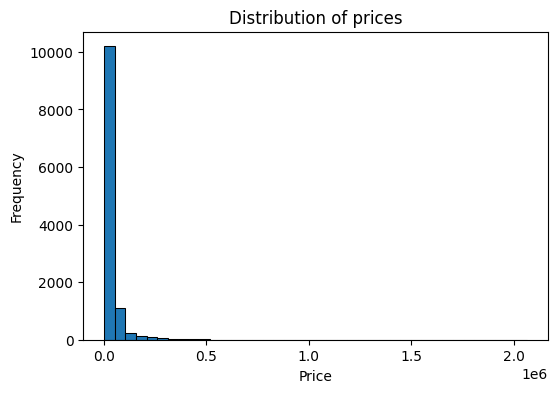

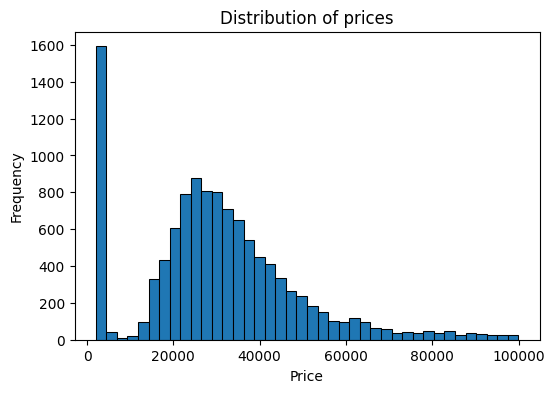

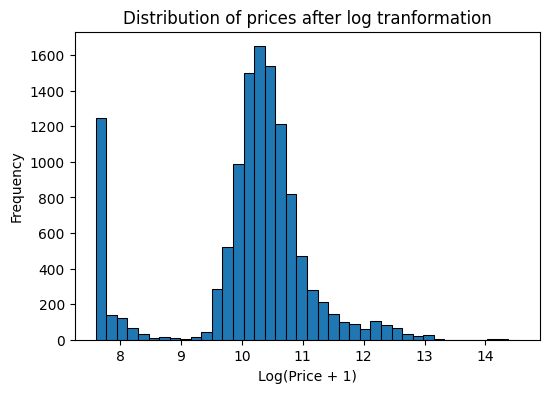

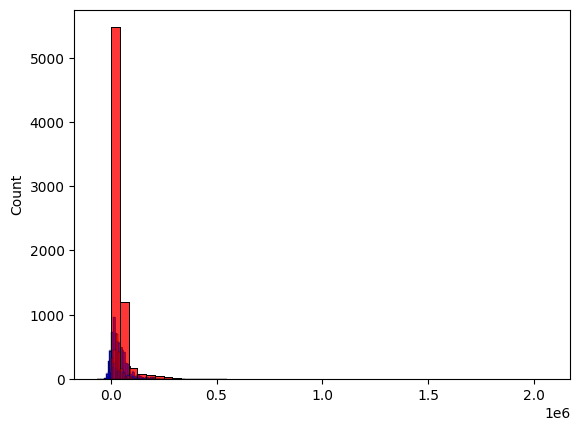

In [2]:
import import_ipynb
from car_price_pred import linear_regression,root_mean_squared_error
# ignore output because this will execute entire notebook once

In [3]:
df = pd.read_csv('data.csv')
len(df)

11914

In [4]:
# Normalization of column names
df.columns = df.columns.str.lower().str.replace(' ', '_')

# Filtering columns with object dtypes
string_columns = list(df.dtypes[df.dtypes == 'object'].index)

# Normalizing them for consistency
for col in string_columns:
    df[col] = df[col].str.lower().str.replace(' ', '_')

# Transformation of Data

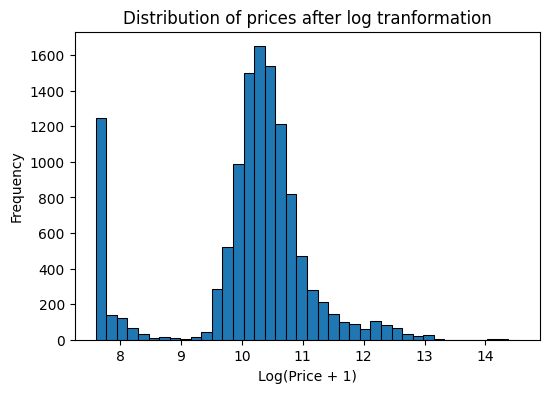

In [5]:
log_price = np.log1p(df.msrp)

plt.figure(figsize=(6, 4))

sns.histplot(log_price, bins=40, alpha=1)
plt.ylabel('Frequency')
plt.xlabel('Log(Price + 1)')
plt.title('Distribution of prices after log tranformation')

plt.show()

In [6]:
df = df.select_dtypes(include = ['int64','float64'])

In [7]:
df.isnull().sum()

year                 0
engine_hp           69
engine_cylinders    30
number_of_doors      6
highway_mpg          0
city_mpg             0
popularity           0
msrp                 0
dtype: int64

In [8]:
df = df.fillna(0)

In [9]:
df.isnull().sum()

year                0
engine_hp           0
engine_cylinders    0
number_of_doors     0
highway_mpg         0
city_mpg            0
popularity          0
msrp                0
dtype: int64

In [10]:
df['number_of_doors'].value_counts()

number_of_doors
4.0    8353
2.0    3160
3.0     395
0.0       6
Name: count, dtype: int64

In [11]:
df = df[df['number_of_doors'] != 0]

In [12]:
def make_df_one_hot_encoding(df,columns):
    new_df = df.copy()
    new_df['year'] = new_df['year'].max()-new_df['year'];
    new_df.rename(columns = {'year':'age'},inplace=True)
    for column in columns:
        unique_values = list(new_df[column].unique().astype('int'))
        for value in unique_values:
            new_df[column+'_%s'% value] = (new_df[column] == value).astype('int')
        del new_df[column]
        return new_df

In [13]:
df_transformed = make_df_one_hot_encoding(df,['number_of_doors'])
df_transformed.head()

,age,engine_hp,engine_cylinders,highway_mpg,city_mpg,popularity,msrp,number_of_doors_2,number_of_doors_4,number_of_doors_3
0,6,335.0,6.0,26,19,3916,46135,1,0,0
1,6,300.0,6.0,28,19,3916,40650,1,0,0
2,6,300.0,6.0,28,20,3916,36350,1,0,0
3,6,230.0,6.0,28,18,3916,29450,1,0,0
4,6,230.0,6.0,28,18,3916,34500,1,0,0


# Setting up validation framework

In [14]:
n = len(df_transformed)

n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - (n_val + n_test)

In [15]:
idx = np.arange(n)
np.random.shuffle(idx)

df_shuffled = df_transformed.iloc[idx]

### 60+20+20 Train+Validation+Test set

In [16]:
df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test = df_shuffled.iloc[n_train+n_val:].copy()

In [17]:
y_train_orig = df_train.msrp.values
y_val_orig = df_val.msrp.values
y_test_orig = df_test.msrp.values

In [18]:
log_y_train = np.log1p(df_train.msrp.values)
log_y_val = np.log1p(df_val.msrp.values)
log_y_test = np.log1p(df_test.msrp.values)

In [19]:
del df_train['msrp']
del df_val['msrp']
del df_test['msrp']

# Modelling

# Linear Regression with regularization

In [20]:
import numpy as np

def linear_regression_with_reg(X, y, r=0.0001):
    # Add bias term
    X = np.column_stack([np.ones(X.shape[0]), X])
    
    XTX = X.T @ X
    XTy = X.T @ y

    # Identity matrix (but do not regularize the bias)
    I = np.eye(XTX.shape[0])
    I[0, 0] = 0

    # Apply regularization
    XTX = XTX + r * I

    # Solve for weights
    w = np.linalg.solve(XTX, XTy)
    return w

In [21]:
X_train = df_train.values

In [22]:
wts = linear_regression_with_reg(X_train,log_y_train)
wts[0],wts[1:]

(np.float64(9.47807292831614),
 array([-9.52652177e-02,  3.63577688e-03,  7.43451880e-02, -1.63537840e-02,
         2.03487027e-02, -4.75244690e-05,  1.02731361e-01,  5.00085294e-02,
        -1.52740094e-01]))

In [23]:
X_train.shape, wts[1:].shape

((7146, 9), (9,))

In [24]:
y_pred = X_train@wts[1:] +wts[0]

In [25]:
root_mean_squared_error(y_train_orig,np.exp(y_pred))

np.float64(44901.14237918698)

In [26]:
wts_no_reg = linear_regression(X_train,log_y_train)
wts_no_reg[0],wts[1:]

(np.float64(-42.770821065177934),
 array([-9.52652177e-02,  3.63577688e-03,  7.43451880e-02, -1.63537840e-02,
         2.03487027e-02, -4.75244690e-05,  1.02731361e-01,  5.00085294e-02,
        -1.52740094e-01]))

In [27]:
y_pred_no_reg = X_train@wts_no_reg[1:] +wts_no_reg[0]

In [28]:
root_mean_squared_error(y_train_orig,np.exp(y_pred_no_reg))

np.float64(44901.1423761308)

### rmse with no log transformed data and with regularization

In [29]:
wts_no_log = linear_regression_with_reg(X_train,y_train_orig,-5)
wts_no_log[0],wts_no_log[1:]

(np.float64(-113311.77993297538),
 array([-3.49487599e+01,  3.06332508e+02,  7.76065233e+03,  1.30121787e+03,
         3.53561540e+02, -3.06254654e+00,  5.04319854e+03, -4.60769382e+03,
        -4.35504715e+02]))

In [30]:
y_pred_no_log = X_train@wts_no_log[1:] +wts_no_log[0]

In [31]:
root_mean_squared_error(y_train_orig,y_pred_no_log)

np.float64(45531.6381224428)

### rmse with no log transformed data and no regularization

In [32]:
wts_no_log_no_reg = linear_regression(X_train,y_train_orig)
wts_no_log_no_reg[0],wts_no_log_no_reg[1:]

(np.float64(-26131.458281087853),
 array([-3.40997300e+01,  3.06450803e+02,  7.75308613e+03,  1.30099691e+03,
         3.53537661e+02, -3.06213795e+00, -8.21398754e+04, -9.17693932e+04,
        -8.75913846e+04]))

In [33]:
y_pred_no_log_no_reg = X_train@wts_no_log_no_reg[1:] +wts_no_log_no_reg[0]

In [34]:
root_mean_squared_error(y_train_orig,y_pred_no_log_no_reg)

np.float64(45531.63682131407)

# Validation

In [35]:
X_val = df_val.values

In [40]:
y_val_pred = X_val@wts[1:] +wts[0]

In [41]:
root_mean_squared_error(y_val_orig,np.exp(y_val_pred))

np.float64(39903.74397736328)

# Testing

In [54]:
X_test = df_test.values

In [55]:
y_test_pred = X_test@wts[1:] +wts[0]

In [56]:
root_mean_squared_error(y_test_orig,np.exp(y_test_pred))

np.float64(33878.490044003665)

In [57]:
root_mean_squared_error(log_y_test,y_test_pred)

np.float64(0.5175068640734916)

##### The best weights we got: In car_price_pred.ipynb, no regularization

In [58]:
w = np.array([ 2.65524577e+01, -9.46143947e-02,  3.77201761e-03,  7.22817605e-02,
       -4.05085000e-03,  1.07663544e-02, -4.53208484e-05, -1.71399994e+01,
       -1.71962940e+01, -1.73716216e+01])

In [59]:
y_test_pred_best = X_test@w[1:] +w[0]

In [60]:
root_mean_squared_error(y_test_orig,np.exp(y_test_pred_best))

np.float64(33799.739452103095)

In [61]:
root_mean_squared_error(log_y_test,y_test_pred_best)

np.float64(0.5174705002123046)